In [1]:
from autoencoders import *
from pdb_utils import *

import pickle
import numpy as np
import pandas as pd
import random

import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
from functools import partial
import sys

from Bio import PDB
import numpy as np
import os
import cv2

import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV

import time

In [20]:
test_pdbs = [i for i in os.listdir("SCOP_Test/")]


test_structures = []

for pdb in test_pdbs:
    pdb_path = os.path.join("SCOP_Test", pdb)
    parser = PDB.PDBParser()
    structure = parser.get_structure(pdb, pdb_path)
    test_structures.append(structure)

print(len(test_structures))

124


In [2]:
def nice_time(start,end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Runtime: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

In [3]:
with open('pickle files/fold_groups.pkl', 'rb') as f:
    fold_dict = pickle.load(f)

In [4]:
with open('pickle files/label_dict.pkl', 'rb') as f:
    label_dict = pickle.load(f)

In [5]:
selected_folds = list(filter(lambda x: x[1]==6, map(lambda x: (x[0],len(x[1])), fold_dict.items())))[:5]
len(selected_folds)

5

In [6]:
s_time = time.time()
structures = []

for fold,_ in selected_folds:
    for pdb in fold_dict[fold]:
        pdb_path = os.path.join("PDBs", pdb+".pdb")
        parser = PDB.PDBParser()
        structure = parser.get_structure(pdb, pdb_path)
        structures.append(structure)
end = time.time()
nice_time(s_time,end)
print(len(structures))

Runtime: 00:00:04.57
30


In [7]:
len(structures)

30

In [9]:
results = {}
for strategy in ["strategy1","strategy2","strategy3"]:
    results[strategy] = []
    for filter_size in [32,64,96,128,256]:
        if strategy == "strategy1":
            # Resize
            matrixdict_s1 = DistanceMatrixDict(structures, resize_strategy="strategy1", resize_to=(filter_size,filter_size),removeSymmetry=True)
            
        elif strategy == "strategy2":
            matrixdict_s1 = DistanceMatrixDict(structures, resize_strategy="strategy2", resize_to=(filter_size,filter_size),sample_size=60)
        
        elif strategy == "strategy3":
            matrixdict_s1 = DistanceMatrixDict(structures, resize_strategy="strategy3", resize_to=(filter_size,filter_size))

        for encoding_size in [50,100,200,500]:
            pdb_names, features = list(matrixdict_s1.keys()), list(matrixdict_s1.values())
            input_size = len(features[0])
            
            # AutoEncoder
            new_features, loss = LinearAutoencoder(features, input_size, encoding_size, 100, learning_rate=0.0001)
            
            # Preparing X and y
            new_feature_dict = {}
            for i in enumerate(pdb_names):
                if "sample" in i[1]:
                    pdb = i[1].split("sample")[0]
                else:
                    pdb = i[1]
                new_feature_dict.setdefault(pdb,[])
                new_feature_dict[pdb].append(new_features[i[0]])

            X = []
            y_fold=[]
            for pdb,vector in new_feature_dict.items():
                X.append(np.average(vector,axis=0))
                y_fold.append(".".join(label_dict[pdb].split(".")[:2]))
            uniques = list(set(y_fold))
            group2id = dict(zip(uniques, range(len(uniques))))
            
            y = np.array(list(map(lambda x: group2id[x], y_fold)))
            X=np.array(X)
            
            # Fold Classification with Random Forest
            train_acc = 0
            test_acc = 0

            sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
            for train_index, test_index in sss.split(X, y):
                X_test, y_test = X[test_index], y[test_index]

                sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
                for a, b in sss1.split(X[train_index], y[train_index]):
                    X_train, y_train = X[train_index][a], y[train_index][a]
                    X_validation, y_validation = X[train_index][b], y[train_index][b]

                # Hyperparameter Optimization with validation set
                params = {'max_depth':range(1,11), 
                      'criterion':('gini', 'entropy'), 
                      'warm_start':(True,False),
                     'n_estimators': (10,50,100,200,500)}

                rf = RandomForestClassifier(random_state=42)
                clf = GridSearchCV(rf, params, cv=2, refit=True)
                clf.fit(X_validation, y_validation)

                # Training best model with train set
                model = clf.best_estimator_
                model.fit(X_train, y_train)

                # Train and Test Accuracy Scores
                train_acc+= model.score(X_train,y_train)
                test_acc += model.score(X_test,y_test)

            train_acc = train_acc/5.
            test_acc = test_acc/5.
            
            
            # Saving Results
            results[strategy].append(((filter_size,encoding_size,input_size), (train_acc,test_acc)))
            print(((filter_size,encoding_size,input_size), (train_acc,test_acc)))

KeyboardInterrupt: 

## Fold Classification with Strategy 1

In [8]:
print("\nCreating distance matrices with Strategy 1")
s_time = time.time()
matrixdict_s1 = DistanceMatrixDict(structures, resize_strategy="strategy1", resize_to=(64,64),removeSymmetry=True)
end = time.time()
nice_time(s_time,end)


Creating distance matrices with Strategy 1
(0, 52, 0, 52)
12
[[0.         3.82694221 6.68301153 ... 0.         0.         0.        ]
 [3.82694221 0.         3.82801032 ... 0.         0.         0.        ]
 [6.68301153 3.82801032 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
(0, 52, 52, 104)
12
[[ 0.          0.          0.         ...  5.50798464  7.89018345
  11.02712059]
 [ 0.          0.          0.         ...  8.00304413 10.95866108
  14.38930893]
 [ 0.          0.          0.         ... 10.32810783 12.70635128
  16.42789841]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(52, 1

Runtime: 00:00:03.65


In [144]:
with open('pickle files/s1128.pkl', 'w') as f:
    pickle.dump(matrixdict_s1,f)

In [9]:
pdb_names, features = list(matrixdict_s1.keys()), list(matrixdict_s1.values())
input_size = len(features[0])
print("Number of samples: %d"%len(pdb_names))
print("Input size: %d"%input_size)

Number of samples: 271
Input size: 4096


In [10]:
s_time = time.time()
new_features, loss = LinearAutoencoder(features, input_size, 200, 100, learning_rate=0.0001)
end = time.time()
nice_time(s_time,end)

Runtime: 00:01:40.77


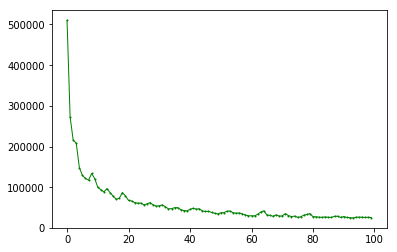

In [11]:
# LOSS GRAPH
fig, ax = plt.subplots()
ax.plot(range(0,len(loss)), loss, 'go-', linewidth=1, markersize=1)

In [13]:
new_feature_dict = {}
for i in enumerate(pdb_names):
    if "sample" in i[1]:
        pdb = i[1].split("sample")[0]
    else:
        pdb = i[1]
    new_feature_dict.setdefault(pdb,[])
    new_feature_dict[pdb].append(new_features[i[0]])
    
X = []
y_family, y_superfamily, y_fold, y_class = [], [], [], []

for pdb,vector in new_feature_dict.items():
    X.append(np.average(vector,axis=0))
    p = pdb.split("sample")[0]
    y_family.append(label_dict[p])
    y_superfamily.append(".".join(label_dict[p].split(".")[:3]))
    y_fold.append(".".join(label_dict[p].split(".")[:2]))
    y_class.append(".".join(label_dict[p].split(".")[0]))
uniques = list(set(y_fold))
group2id = dict(zip(uniques, range(len(uniques))))

X=np.array(X)
y = np.array(list(map(lambda x: group2id[x], y_fold)))

# Random Forest Parameter Optimization

In [16]:
train_acc = 0
test_acc = 0
C=1

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(X, y):
    print("\n\nStratified Split - %d"%C)
    X_test, y_test = X[test_index], y[test_index]
    
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
    for a, b in sss1.split(X[train_index], y[train_index]):
        X_train, y_train = X[train_index][a], y[train_index][a]
        X_validation, y_validation = X[train_index][b], y[train_index][b]
    
    # Hyperparameter Optimization with validation set
    params = {'max_depth':range(1,11), 
          'criterion':('gini', 'entropy'), 
          'warm_start':(True,False),
         'n_estimators': (10,50,100,200,500)}
    
    rf = RandomForestClassifier(random_state=42)
    clf = GridSearchCV(rf, params, cv=2, refit=True)
    clf.fit(X_validation, y_validation)
    print(clf.best_params_)
    
    # Training best model with train set
    model = clf.best_estimator_
    model.fit(X_train, y_train)
    
    # Train and Test Accuracy Scores
    print(model.score(X_train,y_train))
    print(model.score(X_test,y_test))
    train_acc+= model.score(X_train,y_train)
    test_acc += model.score(X_test,y_test)
    
    C+=1
print(train_acc/5.)
print(test_acc/5.)



Stratified Split - 1


/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=2.
  % (min_groups, self.n_splits)), Warning)


{'criterion': 'gini', 'max_depth': 1, 'n_estimators': 10, 'warm_start': True}
0.3888888888888889
0.16666666666666666


Stratified Split - 2


/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:305: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=2.
  % (min_groups, self.n_splits)), Warning)


{'criterion': 'gini', 'max_depth': 1, 'n_estimators': 10, 'warm_start': True}
0.3333333333333333
0.3333333333333333


Stratified Split - 3


/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:305: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=2.
  % (min_groups, self.n_splits)), Warning)


{'criterion': 'gini', 'max_depth': 1, 'n_estimators': 50, 'warm_start': True}
0.5
0.16666666666666666


Stratified Split - 4


/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:305: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=2.
  % (min_groups, self.n_splits)), Warning)


KeyboardInterrupt: 

## Fold Classification with Strategy 2

In [48]:
print("\nCreating distance matrices with Strategy 2")
s_time = time.time()
matrixdict_s2 = DistanceMatrixDict(structures, resize_strategy="strategy2", resize_to=(64,64),sample_size=60)
end = time.time()
nice_time(s_time,end)


Creating distance matrices with Strategy 2
Runtime: 00:02:51.96


In [49]:
pdb_names, features = list(matrixdict_s2.keys()), list(matrixdict_s2.values())
input_size = len(features[0])
print("Number of samples: %d"%len(pdb_names))
print("Input size: %d"%input_size)

Number of samples: 58323
Input size: 4096


In [51]:
print("Linear Autoencoder - 100 epochs")
s_time = time.time()
new_features, loss = LinearAutoencoder(features, input_size, 50, 100, learning_rate=0.0001)
end = time.time()
nice_time(s_time,end)

Linear Autoencoder - 100 epochs


KeyboardInterrupt: 

In [ ]:
# LOSS GRAPH
fig, ax = plt.subplots()
ax.plot(range(0,len(loss)), loss, 'go-', linewidth=1, markersize=1)

In [ ]:
new_feature_dict = {}
for i in enumerate(pdb_names):
    if "sample" in i[1]:
        pdb = i[1].split("sample")[0]
    else:
        pdb = i[1]
    new_feature_dict.setdefault(pdb,[])
    new_feature_dict[pdb].append(new_features[i[0]])
    
X = []
y_family, y_superfamily, y_fold, y_class = [], [], [], []

for pdb,vector in new_feature_dict.items():
    X.append(np.average(vector,axis=0))
    p = pdb.split("sample")[0]
    y_family.append(label_dict[p])
    y_superfamily.append(".".join(label_dict[p].split(".")[:3]))
    y_fold.append(".".join(label_dict[p].split(".")[:2]))
    y_class.append(".".join(label_dict[p].split(".")[0]))
uniques = list(set(y_fold))
group2id = dict(zip(uniques, range(len(uniques))))
y = np.array(list(map(lambda x: group2id[x], y_fold)))

In [ ]:
train_acc = 0
test_acc = 0
C=1

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(X, y):
    print("\n\nStratified Split - %d"%C)
    X_test, y_test = X[test_index], y[test_index]
    
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
    for a, b in sss1.split(X[train_index], y[train_index]):
        X_train, y_train = X[train_index][a], y[train_index][a]
        X_validation, y_validation = X[train_index][b], y[train_index][b]
    
    # Hyperparameter Optimization with validation set
    params = {'max_depth':range(1,11), 
          'criterion':('gini', 'entropy'), 
          'warm_start':(True,False),
         'n_estimators': (10,50,100,200,500)}
    
    rf = RandomForestClassifier(random_state=42)
    clf = GridSearchCV(rf, params, cv=2, refit=True)
    clf.fit(X_validation, y_validation)
    print(clf.best_params_)
    
    # Training best model with train set
    model = clf.best_estimator_
    model.fit(X_train, y_train)
    
    # Train and Test Accuracy Scores
    print(model.score(X_train,y_train))
    print(model.score(X_test,y_test))
    train_acc+= model.score(X_train,y_train)
    test_acc += model.score(X_test,y_test)
    
    C+=1
print(train_acc/5.)
print(test_acc/5.)

# Sample size optimization

In [163]:
train_acc = []
test_acc = []

for size in [5,10,20,30,40,50,60,70,80,90,100,150,200]:
    print(size)
    matrixdict_s2 = DistanceMatrixDict(structures, resize_strategy="strategy2", resize_to=(64,64), sample_size=size)
    pdb_names, features = list(matrixdict_s2.keys()), list(matrixdict_s2.values())
    input_size = len(features[0])
    new_features, loss = LinearAutoencoder(features, input_size, 50, 100, learning_rate=0.0001)
    X = np.array(new_features)
    new_feature_dict = {}
    for i in enumerate(pdb_names):
        if "sample" in i[1]:
            pdb = i[1].split("sample")[0]
        else:
            pdb = i[1]
        new_feature_dict.setdefault(pdb,[])
        new_feature_dict[pdb].append(X[i[0]])
    X_train = []
    y_family, y_superfamily, y_fold, y_class = [], [], [], []

    for pdb,vector in new_feature_dict.items():
        X_train.append(np.average(vector,axis=0))
        p = pdb.split("sample")[0]
        y_family.append(label_dict[p])
        y_superfamily.append(".".join(label_dict[p].split(".")[:3]))
        y_fold.append(".".join(label_dict[p].split(".")[:2]))
        y_class.append(".".join(label_dict[p].split(".")[0]))
    
    rf = RandomForestClassifier(random_state=0, criterion='entropy', warm_start=True, n_estimators=50, max_depth=3)
    acc_train, acc_test = pdbClassifier(np.array(X_train), np.array(y_fold) , label_dict, rf)
    train_acc.append(acc_train)
    test_acc.append(acc_test)

5
Number of labels: 19
Runtime: 00:00:00.20
TRAIN SCORES

average accuracy_score:  0.7473684210526317
average precision_score:  0.7744872233030129
average recall_score:  0.7473684210526317
TEST SCORES

average accuracy_score:  0.6684210526315789
average precision_score:  0.6682456140350876
average recall_score:  0.6684210526315789
10
Number of labels: 19
Runtime: 00:00:00.20
TRAIN SCORES

average accuracy_score:  0.7677631578947368
average precision_score:  0.8091685653527758
average recall_score:  0.7677631578947368
TEST SCORES

average accuracy_score:  0.718421052631579
average precision_score:  0.7537719298245614
average recall_score:  0.718421052631579
20
Number of labels: 19
Runtime: 00:00:00.22
TRAIN SCORES

average accuracy_score:  0.7868421052631579
average precision_score:  0.8243859357017251
average recall_score:  0.7868421052631579
TEST SCORES

average accuracy_score:  0.7473684210526316
average precision_score:  0.7975438596491228
average recall_score:  0.7473684210526316
3

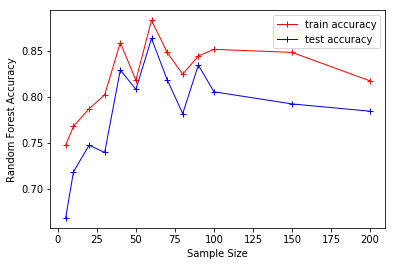

In [165]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

all_x = a[:5] + train_acc + a[6:]
all_y = b[:5] + test_acc + b[6:]

ax.plot([5,10,20,30,40,50,60,70,80,90,100,150,200],np.array(train_acc)/10, "r-+", linewidth=1, label="train accuracy")
ax.plot([5,10,20,30,40,50,60,70,80,90,100,150,200],np.array(test_acc)/10, "b-+", linewidth=1, label="test accuracy")
ax.legend()
ax.set_ylabel("Random Forest Accuracy")
ax.set_xlabel("Sample Size")
plt.show()

In [171]:
train_acc[6]

8.828947368421053

In [172]:
test_acc[6]

8.631578947368421

## Sparse Autoencoder

In [118]:
def kl_divergence(p, q):
    # Kullback Leibler divergence
    return p * tf.log(p / q) + (1 - p) * tf.log((1 - p) / (1 - q))

def SparseAutoencoder(X_train, n_input, n_hidden, n_iteration, batch_size=20, learning_rate = 0.001,sparsity_target = 0.1, sparsity_weight = 0.2):
    n_inputs = n_input # input is flatten version of input matrix
    n_hidden = n_hidden
    n_outputs = n_inputs
    
    sparsity_target = sparsity_target
    sparsity_weight = sparsity_weight

    learning_rate = learning_rate

    X = tf.placeholder(tf.float32, shape=[None, n_inputs])
    hidden = fully_connected(X, n_hidden) # not shown
    outputs = fully_connected(hidden, n_outputs)                     # not shown

    hidden_mean = tf.reduce_mean(hidden, axis=0) # batch mean
    kl = kl_divergence(sparsity_target, hidden_mean)
    sparsity_loss = tf.reduce_sum(kl)
    reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE
    loss = reconstruction_loss + sparsity_weight * sparsity_loss

    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

    init = tf.global_variables_initializer()

    n_iterations = n_iteration # Number of iterations
    codings = hidden # the output of the hidden layer provides the codings

    with tf.Session() as sess:
        init.run()
        loss = []
        for iteration in range(n_iterations):
            sys.stdout.flush()
            iteration_loss = []
            
            start = 0
            end = batch_size
            print iteration
            while start < len(X_train):
                X_batch = X_train[start:end]
                _, loss_val = sess.run([training_op, hidden], feed_dict={X: X_batch}) # no labels (unsupervised)
                start+=batch_size
                end+=batch_size
                iteration_loss.append(loss_val)
                print loss_val
            loss.append(sum(iteration_loss)/float(len(X_train)))

        # Test on the same protein
        codings_val = codings.eval(feed_dict={X: X_train})

    return codings_val, loss

In [119]:
print("Sparse Autoencoder - 100 epochs")
s_time = time.time()
new_features, loss = SparseAutoencoder(features, input_size, 50, 10, batch_size =20, learning_rate=0.001,sparsity_target=0.3,sparsity_weight=0.2)
end = time.time()
nice_time(s_time,end)

# LOSS GRAPH
fig, ax = plt.subplots()
ax.plot(range(0,len(loss)), loss, 'go-', linewidth=1, markersize=1)

Sparse Autoencoder - 100 epochs
0
[[4.87974167e+00 0.00000000e+00 1.69265366e+01 1.62925243e+00
  7.63184738e+00 0.00000000e+00 0.00000000e+00 3.72521162e+00
  2.64244289e+01 4.63035431e+01 1.35782404e+01 0.00000000e+00
  0.00000000e+00 3.30588036e+01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 1.67468681e+01
  3.92055016e+01 0.00000000e+00 8.08483791e+00 1.26738300e+01
  1.97836056e+01 0.00000000e+00 3.99948349e+01 0.00000000e+00
  3.45615578e+01 0.00000000e+00 0.00000000e+00 2.03316307e+01
  0.00000000e+00 2.63177013e+00 7.61694908e-01 1.34636841e+01
  0.00000000e+00 4.81317663e+00 1.96373444e+01 0.00000000e+00
  2.03511810e+01 0.00000000e+00 1.34109802e+01 4.74850960e+01
  2.33902073e+01 0.00000000e+00 0.00000000e+00 2.66866112e+00
  0.00000000e+00 0.00000000e+00]
 [8.87278366e+00 1.25762920e+01 1.65528774e+01 7.16990566e+00
  9.82933712e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  9.84496403e+00 5.42515259e+01 3.44213343e+00 4.94433117e+00
  9

[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan na

[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan na

[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan na

[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan na

ValueError: operands could not be broadcast together with shapes (20,50) (8,50) 

In [82]:
X = np.array(new_features)

In [83]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, penalty="l2", multi_class='multinomial', solver='lbfgs')
pdbClassifier(X, y_fold, label_dict, clf)

Number of labels: 19

Stratified Cross Validation - 1
Training...

Stratified Cross Validation - 2
Training...

Stratified Cross Validation - 3
Training...

Stratified Cross Validation - 4
Training...

Stratified Cross Validation - 5
Training...

Stratified Cross Validation - 6
Training...

Stratified Cross Validation - 7
Training...

Stratified Cross Validation - 8
Training...

Stratified Cross Validation - 9
Training...

Stratified Cross Validation - 10
Training...
Runtime: 00:00:00.52
TRAIN SCORES

average accuracy_score:  0.3019736842105263
average precision_score:  0.21593046122370688
average recall_score:  0.3019736842105263
TEST SCORES

average accuracy_score:  0.32631578947368417
average precision_score:  0.2142948279790385
average recall_score:  0.32631578947368417
